<a href="https://colab.research.google.com/github/NurbolSDU/algos/blob/main/DL_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchmetrics pytorch-fid matplotlib scikit-learn tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
!pip install torch-fidelity pytorch-fid --quiet

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
print(len(train_ds), len(test_ds))


60000 10000


In [83]:
class VAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),  # -> 14×14
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), # -> 7×7
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, z_dim)
        self.fc_logvar = nn.Linear(64*7*7, z_dim)

        self.fc_up = nn.Linear(z_dim, 64*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.ReLU(),  # 7→14
            nn.ConvTranspose2d(32, 1, 3, 2, 1, 1), nn.Tanh()    # 14→28
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_up(z).view(-1, 64, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decode(z)
        return xhat, mu, logvar


def vae_loss(xhat, x, mu, logvar, beta=1.0):
    recon = F.mse_loss(xhat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta*kld, recon, kld


In [84]:
vae = VAE(z_dim=64).to(device)
opt = optim.Adam(vae.parameters(), lr=2e-4, betas=(0.5, 0.999))

EPOCHS_VAE = 100
for epoch in range(1, EPOCHS_VAE+1):
    vae.train()
    total = recon_tot = kld_tot = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        xhat, mu, logvar = vae(x)
        loss, recon, kld = vae_loss(xhat, x, mu, logvar, beta=1.0)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item(); recon_tot += recon.item(); kld_tot += kld.item()
    print(f"[VAE] Epoch {epoch:03d}  total:{total/len(train_ds):.2f}  "
          f"recon:{recon_tot/len(train_ds):.2f}  kld:{kld_tot/len(train_ds):.2f}")

    if epoch % 10 == 0:
        vae.eval()
        with torch.no_grad():
            imgs, _ = next(iter(test_loader))
            imgs = imgs[:8].to(device)
            recon, _, _ = vae(imgs)
            grid = utils.make_grid(torch.cat([imgs, recon]), nrow=8, normalize=True, value_range=(-1,1))
        utils.save_image(grid, f"vae_recon_epoch{epoch}.png")


[VAE] Epoch 001  total:135.10  recon:98.31  kld:36.80
[VAE] Epoch 002  total:90.63  recon:49.28  kld:41.35
[VAE] Epoch 003  total:82.20  recon:42.08  kld:40.13
[VAE] Epoch 004  total:77.63  recon:38.86  kld:38.77
[VAE] Epoch 005  total:74.73  recon:37.01  kld:37.72
[VAE] Epoch 006  total:72.62  recon:35.85  kld:36.77
[VAE] Epoch 007  total:71.06  recon:34.98  kld:36.08
[VAE] Epoch 008  total:69.89  recon:34.33  kld:35.56
[VAE] Epoch 009  total:68.98  recon:33.81  kld:35.17
[VAE] Epoch 010  total:68.27  recon:33.38  kld:34.89
[VAE] Epoch 011  total:67.65  recon:33.02  kld:34.63
[VAE] Epoch 012  total:67.16  recon:32.72  kld:34.44
[VAE] Epoch 013  total:66.67  recon:32.43  kld:34.24
[VAE] Epoch 014  total:66.32  recon:32.21  kld:34.11
[VAE] Epoch 015  total:65.91  recon:31.99  kld:33.92
[VAE] Epoch 016  total:65.64  recon:31.82  kld:33.82
[VAE] Epoch 017  total:65.41  recon:31.69  kld:33.72
[VAE] Epoch 018  total:65.12  recon:31.54  kld:33.58
[VAE] Epoch 019  total:64.93  recon:31.39  kl

In [85]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, out_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),    nn.BatchNorm2d(64),  nn.ReLU(True),
            nn.ConvTranspose2d(64, out_ch, 4, 2, 1), nn.Tanh()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1),   nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 1, 7, 1, 0),    nn.Sigmoid()
        )
    def forward(self, x): return self.net(x).view(-1, 1).squeeze(1)

In [87]:
G = Generator(z_dim=100, out_ch=1).to(device)
D = Discriminator(in_ch=1).to(device)
optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

FIXED_Z = torch.randn(64, 100, 1, 1, device=device)

EPOCHS_GAN = 200
for epoch in range(1, EPOCHS_GAN + 1):
    for real, _ in train_loader:
        real = real.to(device)
        b = real.size(0)

        z = torch.randn(b, 100, 1, 1, device=device)
        fake = G(z).detach()
        d_real = D(real)
        d_fake = D(fake)
        lossD = criterion(d_real, torch.ones_like(d_real) * 0.9) + \
                criterion(d_fake, torch.zeros_like(d_fake))
        optD.zero_grad()
        lossD.backward()
        optD.step()

        z = torch.randn(b, 100, 1, 1, device=device)
        fake = G(z)
        out = D(fake)
        lossG = criterion(out, torch.ones_like(out))
        optG.zero_grad()
        lossG.backward()
        optG.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            samples = G(FIXED_Z)
            grid = utils.make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
        utils.save_image(grid, f"gan_samples_epoch{epoch}.png")
    print(f"[GAN] Epoch {epoch:03d}  D:{lossD.item():.4f}  G:{lossG.item():.4f}")


[GAN] Epoch 001  D:0.6270  G:2.1690
[GAN] Epoch 002  D:0.7159  G:1.6130
[GAN] Epoch 003  D:0.7701  G:1.4350
[GAN] Epoch 004  D:0.7754  G:1.4295
[GAN] Epoch 005  D:0.9455  G:1.4683
[GAN] Epoch 006  D:0.7285  G:1.3974
[GAN] Epoch 007  D:0.8116  G:1.7040
[GAN] Epoch 008  D:0.9602  G:2.4997
[GAN] Epoch 009  D:0.6350  G:1.8744
[GAN] Epoch 010  D:0.5703  G:1.9711
[GAN] Epoch 011  D:0.7142  G:2.5571
[GAN] Epoch 012  D:0.7801  G:1.4326
[GAN] Epoch 013  D:0.6772  G:2.1073
[GAN] Epoch 014  D:0.9108  G:2.0556
[GAN] Epoch 015  D:0.7681  G:2.5201
[GAN] Epoch 016  D:0.6661  G:2.1717
[GAN] Epoch 017  D:0.6720  G:1.8980
[GAN] Epoch 018  D:0.7293  G:1.4637
[GAN] Epoch 019  D:0.8279  G:2.7939
[GAN] Epoch 020  D:0.7273  G:2.0691
[GAN] Epoch 021  D:0.6675  G:2.9844
[GAN] Epoch 022  D:0.5381  G:3.3696
[GAN] Epoch 023  D:0.7811  G:3.7516
[GAN] Epoch 024  D:0.6076  G:2.0787
[GAN] Epoch 025  D:0.5934  G:2.8614
[GAN] Epoch 026  D:0.6178  G:3.2836
[GAN] Epoch 027  D:0.6830  G:1.9642
[GAN] Epoch 028  D:0.6403  G

In [88]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

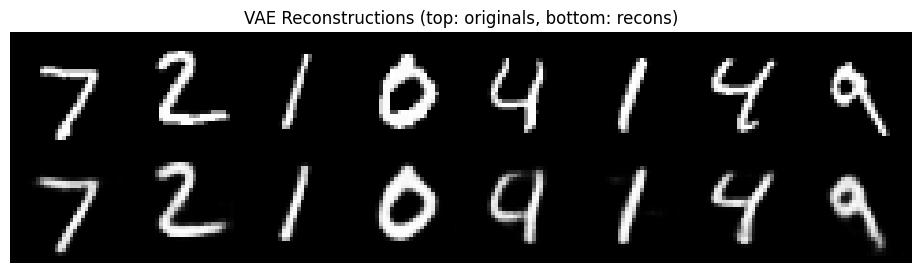

In [91]:
vae.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:8].to(device)
    recons, _, _ = vae(imgs)
    grid = utils.make_grid(torch.cat([imgs, recons]), nrow=8, normalize=True, value_range=(-1,1))

plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.title("VAE Reconstructions (top: originals, bottom: recons)")
plt.show()


In [92]:
vae.eval()
mse_sum, n_pix = 0.0, 0
with torch.no_grad():
    for x,_ in test_loader:
        x = x.to(device)
        xhat,_,_ = vae(x)
        mse_sum += F.mse_loss(xhat, x, reduction='sum').item()
        n_pix += x.numel()
print("VAE reconstruction MSE per pixel:", mse_sum / n_pix)


VAE reconstruction MSE per pixel: 0.036884005145637354


In [93]:
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 64, device=device)
    samples_vae = vae.decode(z)
    utils.save_image(samples_vae, "vae_samples.png", nrow=8, normalize=True, value_range=(-1,1))


G.eval()
with torch.no_grad():
    z = torch.randn(64, 100, 1, 1, device=device)
    samples_gan = G(z)
    utils.save_image(samples_gan, "gan_samples.png", nrow=8, normalize=True, value_range=(-1,1))


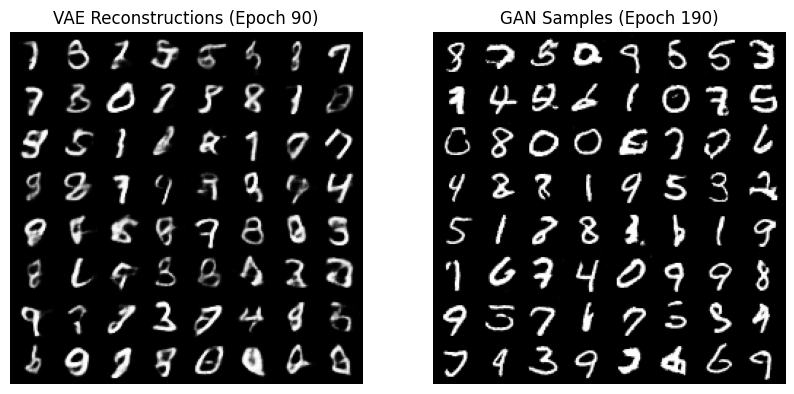

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(Image.open("/content/vae_samples.png"))
axes[0].set_title("VAE Reconstructions (Epoch 90)")
axes[0].axis("off")

axes[1].imshow(Image.open("/content/gan_samples.png"))
axes[1].set_title("GAN Samples (Epoch 190)")
axes[1].axis("off")

plt.show()


In [112]:
os.makedirs("fid_vae", exist_ok=True)

count = 0
vae.eval()
with torch.no_grad():
    while count < 10000:
        z = torch.randn(64, 64, device=device)
        samples = vae.decode(z)
        for img in samples:
            save_image((img * 0.5 + 0.5).clamp(0, 1), f"/content/fid_vae/{count:05d}.png")
            count += 1
            if count >= 10000:
                break

!python -m pytorch_fid real /content/fid_vae --batch-size 256


100% 38/38 [00:37<00:00,  1.00it/s]
100% 40/40 [00:38<00:00,  1.05it/s]
FID:  31.611771131521152


In [97]:
from torchvision.utils import save_image

os.makedirs("real", exist_ok=True)
for i,(x,_) in enumerate(test_loader):
    for j in range(x.size(0)):
        save_image((x[j]*0.5+0.5).clamp(0,1), f"real/{i*64+j:05d}.png")
    if i>150: break   # about 10k imgs

os.makedirs("gan_eval", exist_ok=True)
G.eval()
with torch.no_grad():
    for i in range(10000):
        z = torch.randn(1, 100, 1, 1, device=device)
        img = (G(z)*0.5 + 0.5).clamp(0,1)
        save_image(img, f"gan_eval/{i:05d}.png")

!python -m pytorch_fid real gan_eval


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 106MB/s]
100% 195/195 [00:39<00:00,  4.95it/s]
100% 200/200 [00:38<00:00,  5.16it/s]
FID:  5.989229607373346


In [98]:
from torch_fidelity import calculate_metrics
metrics = calculate_metrics(input1='gan_eval', isc=True, fid=False, cuda=torch.cuda.is_available())
print("Inception Score:", metrics['inception_score_mean'])

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 228MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "gan_eval" with extensions png,jpg,jpeg
Found 10000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: User

Inception Score: 2.1849728863995224


Inception Score: 2.1849728863995224 ± 0.025340088466278853


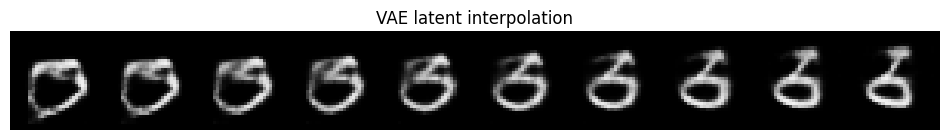

In [99]:
vae.eval()
with torch.no_grad():
    z1 = torch.randn(1, 64, device=device)
    z2 = torch.randn(1, 64, device=device)
    alphas = torch.linspace(0, 1, 10, device=device).unsqueeze(1)
    z_interp = (1 - alphas)*z1 + alphas*z2
    imgs = vae.decode(z_interp)
    grid = utils.make_grid(imgs, nrow=10, normalize=True, value_range=(-1,1))

plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.title("VAE latent interpolation")
plt.show()


Explained variance ratio: [0.06021852 0.05851753 0.05096888 0.04997028 0.0459379 ]


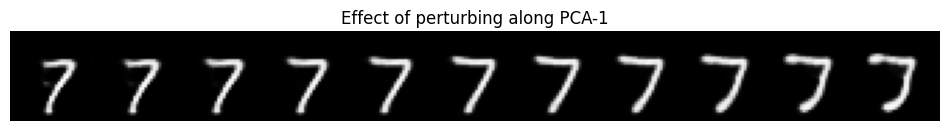

In [113]:
from sklearn.decomposition import PCA

latents = []
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        _, mu, _ = vae(x)
        latents.append(mu.cpu())
latents = torch.cat(latents, dim=0).numpy()


pca = PCA(n_components=5)
Z_pca = pca.fit_transform(latents)
print("Explained variance ratio:", pca.explained_variance_ratio_)

pc_index = 0
direction = torch.tensor(pca.components_[pc_index], dtype=torch.float32, device=device)

z0 = torch.tensor(latents[0], dtype=torch.float32, device=device)

alphas = torch.linspace(-3, 3, 11, device=device)
z_perturbed = torch.stack([z0 + a * direction for a in alphas])

with torch.no_grad():
    imgs = vae.decode(z_perturbed)
grid = utils.make_grid(imgs, nrow=11, normalize=True, value_range=(-1,1))
plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.title(f"Effect of perturbing along PCA-{pc_index+1}")
plt.show()


In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def extract_mu(loader):
    vae.eval()
    Z,Y = [],[]
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            _, mu, _ = vae(x)
            Z.append(mu.cpu())
            Y.append(y)
    return torch.cat(Z).numpy(), torch.cat(Y).numpy()

Ztr,Ytr = extract_mu(train_loader)
Zte,Yte = extract_mu(test_loader)

clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
clf.fit(Ztr, Ytr)
print("Latent μ logistic-regression accuracy:", accuracy_score(Yte, clf.predict(Zte)))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Latent μ logistic-regression accuracy: 0.9445


In [108]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

target_digit = 3
scores, labels = [], []

vae.eval()
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        xhat,_,_ = vae(x)
        err = ((xhat - x)**2).flatten(1).mean(1).cpu().numpy()
        scores.extend(err)
        labels.extend((y.numpy()==target_digit).astype(int))

scores, labels = np.array(scores), np.array(labels)
print("Anomaly ROC-AUC:", roc_auc_score(labels, scores))
print("Anomaly PR-AUC :", average_precision_score(labels, scores))


Anomaly ROC-AUC: 0.592468137174024
Anomaly PR-AUC : 0.12131465395492069


In [107]:
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:1000].flatten(1)
real_dists = torch.cdist(real_imgs, real_imgs, p=2).mean().item()
print("Mean pairwise distance (real MNIST):", real_dists)

Mean pairwise distance (real MNIST): 20.025798797607422


In [114]:
with torch.no_grad():
    z = torch.randn(1000, 64, device=device)
    fake_batch = vae.decode(z)

real_batch, _ = next(iter(test_loader))
real_batch = real_batch[:1000].to(device)

real_flat = real_batch.flatten(1)
fake_flat = fake_batch.flatten(1)

dists = torch.cdist(fake_flat, fake_flat, p=2)
mean_pairwise = dists.mean().item()
print(f"VAE Mean pairwise distance: {mean_pairwise:.4f}")

with torch.no_grad():
    z = torch.randn(1000, 100, 1, 1, device=device)
    samples = G(z).flatten(1)
    dists = torch.cdist(samples, samples, p=2)
mean_dist = dists.mean().item()
print("GAN Mean pairwise distance:", mean_dist)

VAE Mean pairwise distance: 17.0020
GAN Mean pairwise distance: 20.1146297454834


In [115]:
with torch.no_grad():
    z = torch.randn(1000, 64, device=device)
    fake_batch = vae.decode(z)

real_batch, _ = next(iter(test_loader))
real_batch = real_batch[:1000].to(device)

real_flat = real_batch.flatten(1)
fake_flat = fake_batch.flatten(1)

dists_rf = torch.cdist(real_flat, fake_flat, p=2)
nearest = dists_rf.min(1).values.mean().item()
print(f"VAE Average nearest-gen distance to real sample: {nearest:.4f}")

real_batch, _ = next(iter(test_loader))
real_batch = real_batch[:1000].to(device)
with torch.no_grad():
    z = torch.randn(1000, 100, 1, 1, device=device)
    fake_batch = G(z)

real_flat = real_batch.flatten(1)
fake_flat = fake_batch.flatten(1)
dists = torch.cdist(real_flat, fake_flat, p=2)
nearest = dists.min(1).values.mean().item()
print("GAN Average nearest-gen distance to real sample:", nearest)


VAE Average nearest-gen distance to real sample: 11.1592
GAN Average nearest-gen distance to real sample: 11.73009204864502
